# Figure 2: Denmark Strait freshwater transport reconstructions

This notebook will reproduce Figure 2 from  E. Boland et al. 2025 (doi to come). This requires input datafiles of the monthly time series of Denmark Strait FW flux from the solution and reconstructions based on adjoint sensitivities to run - please see the README for details.

Data files were created as follows:
- m_horflux_fw_denm.0000000129.data, found in {DATA_DIR}, is generated by running the ECCOv4r4 solution using the masks DenmarkStrait_mask* generated using generate_masks.py and modified code found in https://doi.org/10.5281/zenodo.17225253
- denstr_fwflux_4yrecon_{eyear}_{var}.nc, found in RECON_DIR, is generated by running convolve.py then reconstruct.py

Please attribute any plots or code from this notebook using the DOI from Zenodo: https://doi.org/10.5281/zenodo.17225514

E Boland Jan 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [5]:
import utils as ut
import xarray as xr
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from inputs import FCNAME, DATA_DIR, RECON_DIR, eyears

In [6]:
plotvars=['all_OCE','wind_OCE','adxx_qnetXoceQnet_sum', 'adxx_empmrXoceFWflx_sum']
plotvar_labels=dict(zip(plotvars,['Total Recon','Wind Stress','Heat','Fresh Water']))

In [7]:
fc=ut.get_soln(FCNAME,DATA_DIR)
fc_climanom,fc_mth=ut.soln_anoms(fc)

read_llc_to_tiles: full_filename:  /users/emmomp/data/canari/experiments/fwd_26y/m_horflux_fw_denm.0000000129.data


In [8]:
YY=[]
for eyear in eyears:
    YY_year=xr.open_mfdataset(f'{RECON_DIR}/denstr_fwflux_4yrecon_{eyear}_*.nc',combine='nested',concat_dim=None).assign_coords({'eyear':eyear}).sel(time=slice('1996-01-01',None))
    YY.append(YY_year)
YY=xr.concat(YY,'eyear',coords='minimal').load()
YY_dt=YY.to_array().copy(data=signal.detrend(YY.to_array())).to_dataset('variable')

XX=fc_climanom # detrended in utils

In [9]:
ev = (1-(XX-YY_dt).var('time')/XX.var('time')).load()
ev_mean=(1-(XX-YY_dt.mean('eyear')).var('time')/XX.var('time')).load()

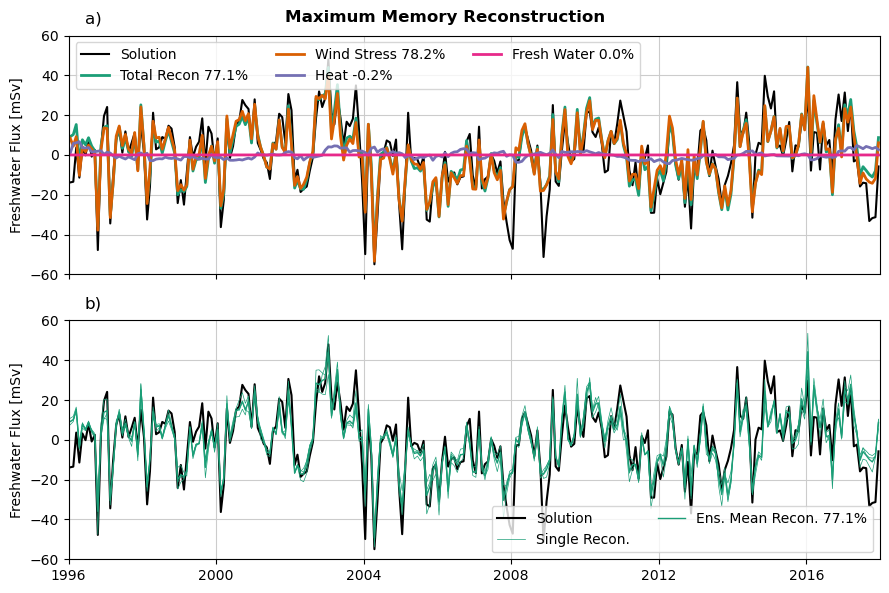

In [18]:
colors=plt.get_cmap('Dark2')
plt.figure(figsize=[9,6])
ylims=[60,35,45]

ax=plt.subplot(2,1,1)
(XX/1e3).plot(color='k',label='Solution',ax=ax)
for iv,var in enumerate(plotvars):
    (YY_dt[var]/1e3).mean('eyear').plot(linewidth=2,color=colors(iv),label=f'{plotvar_labels[var]} {ev_mean[var]*100:2.1f}%',ax=ax)
plt.ylabel('Freshwater Flux [mSv]')
plt.title('')
plt.xlim([np.datetime64('1996-01-01'),np.datetime64('2017-12-31')])
plt.grid(axis='both', color='0.8')
plt.xlabel('')
ax.set_xticklabels([])
plt.ylim([-ylims[nplot],ylims[nplot]])
plt.legend(ncol=3)
plt.text(0.02,1.05,'a)',fontsize=12,transform=ax.transAxes)

ax=plt.subplot(2,1,2)
var='all_OCE'
iv=0
ppx=(XX/1e3).plot(color='k',label='Solution',ax=ax)
pp1=(YY_dt[var]/1e3).plot(hue='eyear',linewidth=0.5,color=colors(iv),add_legend=False,ax=ax)
pp2=(YY_dt[var]/1e3).mean('eyear').plot(linewidth=1,color=colors(iv),ax=ax)
plt.ylabel('Freshwater Flux [mSv]')
plt.title('')
plt.xlim([np.datetime64('1996-01-01'),np.datetime64('2017-12-31')])
plt.grid(axis='both', color='0.8')
plt.legend([ppx[0],pp1[0],pp2[0]],['Solution','Single Recon.',f'Ens. Mean Recon. {ev_mean[var]*100:2.1f}%'],ncol=2)
plt.xlabel('')
plt.ylim([-ylims[nplot],ylims[nplot]])
plt.text(0.02,1.05,'b)',fontsize=12,transform=ax.transAxes)

plt.tight_layout()
plt.suptitle('Maximum Memory Reconstruction',fontsize=12,fontweight='bold',y=0.98)
plt.savefig(f'../plots/fig2_fullrecons.pdf',bbox_inches='tight')